In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

----load the training data

In [2]:
df_train=pd.read_csv("training_data.csv")

In [3]:
df_train.head()

,review_id,business_id,user_id,text,date,stars
0,3223,2055,2533,"Sometimes things happen, and when they do this...",2010-12-30,5
1,9938,4165,6371,I know Kerrie through my networking and we ben...,2011-04-26,5
2,7123,869,4929,Love their pizza!!!\nVery fresh. Their cannoli...,2012-09-28,5
3,3601,1603,2789,Being from NJ I am always on the prowl for my ...,2009-06-07,4
4,3948,2347,1245,We have tried this spot a few times and each v...,2011-02-20,4


In [4]:
df_train.shape

(7997, 6)

In [5]:
df_train.review_id.unique().shape

(7997,)

In [6]:
df_train.business_id.unique().shape

(3637,)

In [7]:
df_train.user_id.unique().shape

(5400,)

as what showed above, we can know that users not only rate once and items are not only rated once

-->we can use either "Collaborative Filtering" or "Matrix Factorization" to predict rating

In [4]:
text_train=df_train['text']
text_train.head()

0    Sometimes things happen, and when they do this...
1    I know Kerrie through my networking and we ben...
2    Love their pizza!!!\nVery fresh. Their cannoli...
3    Being from NJ I am always on the prowl for my ...
4    We have tried this spot a few times and each v...
Name: text, dtype: object

----text processing

----CountVectorizer()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vectorizer = CountVectorizer()
vectorizer.fit(text_train)
cv_train=vectorizer.transform(text_train) #sparse matrix, [n_samples, n_features]

In [7]:
cv_train.shape #[n_samples, n_features]

(7997, 26351)

In [12]:
vectorizer.get_feature_names()[-10:]

['zur',
 'zuzu',
 'zuzus',
 'zweigel',
 'zwiebel',
 'zzed',
 'zzzzzzzzzzzzzzzzz',
 'éclairs',
 'école',
 'òc']

----train's label

In [8]:
star_train=df_train.stars

In [9]:
df_test=pd.read_csv("test_data.csv")
text_test=df_test.text

In [10]:
df_sub=pd.read_csv("sample_submission.csv",names=np.array(['id','stars']))
df_sub.head()

,id,stars
0,2713,1
1,4734,1
2,5598,5
3,9545,1
4,1471,4


In [11]:
cv_test=vectorizer.transform(text_test)

In [12]:
star_test=df_sub.stars
np.array(star_test)

array([1, 1, 5, ..., 4, 2, 5], dtype=int64)

In [13]:
star_train.unique()

array([5, 4, 3, 2, 1], dtype=int64)

In [14]:
train_business_id=np.array(df_train.business_id)
train_business_id=train_business_id[:,np.newaxis]
train_business_id.shape

(7997, 1)

In [15]:
train_user_id=np.array(df_train.user_id)
train_user_id=train_user_id[:,np.newaxis]
train_user_id.shape

(7997, 1)

In [16]:
test_business_id=np.array(df_test.business_id)
test_business_id=test_business_id[:,np.newaxis]
test_business_id.shape

(2003, 1)

In [17]:
test_user_id=np.array(df_test.user_id)
test_user_id=test_user_id[:,np.newaxis]
test_user_id.shape

(2003, 1)

In [18]:
import math
math.isnan(train_business_id.any())

False

In [19]:
cv_train=cv_train.toarray()
cv_train.shape

(7997, 26351)

In [20]:
cv_test=cv_test.toarray()
cv_test.shape

(2003, 26351)

In [21]:
trin_feature=np.concatenate((train_business_id,train_user_id),axis=1)

In [22]:
train_feature=np.concatenate((cv_train,trin_feature),axis=1)

In [23]:
ts_feature=np.concatenate((test_user_id,test_business_id),axis=1)

In [24]:
test_feature=np.concatenate((cv_test,ts_feature),axis=1)

----classifier prediction

----LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression

logr=LogisticRegression()
logr.fit(train_feature,star_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
logr.score(test_feature,star_test)

0.2016974538192711

----KNeighborsClassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier()

In [33]:
rng = np.random.RandomState(0)

permutation = rng.permutation(len(star_train))
train_feature_, star_train_ = train_feature[permutation], star_train[permutation]

In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNC, train_feature, star_train)
print(scores)
print(np.mean(scores))

[0.29096363 0.29294824 0.29016517]
0.29135901059024555


In [34]:
KNC=KNeighborsClassifier(n_neighbors=20).fit(train_feature,star_train)
star_pred_cvK=KNC.predict(test_feature)

In [35]:
star_pred_cvK

array([4, 4, 5, ..., 5, 4, 4], dtype=int64)

In [36]:
np.mean(star_pred_cvK==star_test)

0.21218172740888666

In [42]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5)
cross_val_score(logr, train_feature, star_train, cv=cv)

MemoryError: 

AttributeError: module 'matplotlib.pyplot' has no attribute 'lagend'

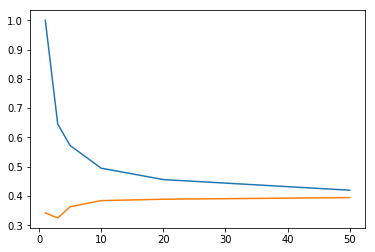

In [182]:
from sklearn.model_selection import validation_curve
n_neighbors=[1,3,5,10,20,50]
train_errors,validation_errors=validation_curve(KNC,cv_train,star_train,param_name='n_neighbors',param_range=n_neighbors,cv=cv)

plt.plot(n_neighbors,train_errors.mean(axis=1),label='training error')
plt.plot(n_neighbors,validation_errors.mean(axis=1),label='validation error')
plt.legend(loc='best')

----regression prediction

----LinearRegression

regressor.score(): Returns the coefficient of determination R^2 of the prediction.The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().

In [27]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()

In [28]:
LR.fit(train_feature,star_train)
star_pred_LR=LR.predict(test_feature)

In [29]:
star_pred_LR

array([ -5.81370851, -40.32445587,  -9.11735862, ...,  -0.34068946,
         1.7047582 ,   4.52181522])

In [30]:
LR.score(test_feature,star_test)

-61.95347483950877

In [31]:
from sklearn.neighbors import KNeighborsRegressor
KNR=KNeighborsRegressor()

In [32]:
KNR.fit(train_feature,star_train)
star_pred_KNR=KNR.predict(test_feature)

In [33]:
KNR.score(test_feature,star_test)

-0.3408119007580217

In [34]:
n_neighbors=[1,3,5,10,20,50]

for n in n_neighbors:
    knr=KNeighborsRegressor(n_neighbors=n)
    knr.fit(cv_train,star_train)
    print(n,knr.score(cv_test,star_test))

MemoryError: 

In [212]:
knr=KNeighborsRegressor(n_neighbors=100)
knr.fit(train_feature,star_train)
knr.score(test_feature,star_test)

-0.47294908827032045

----svm

In [25]:
from sklearn import svm
clf=svm.SVC() #default: kernel='rbf'

In [26]:
clf.fit(train_feature,star_train)
clf.score(test_feature,star_test)

0.21168247628557163

In [217]:
clf_l=svm.SVC(kernel='linear')
clf_l.fit(train_feature,star_train)
clf_l.score(test_feature,star_test)

0.20419370943584622

----GridSearchCV(SVR())

In [225]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
cv=KFold(shuffle=True)

from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10],'gamma':[0.001,0.01,0.1,1]}

grid=GridSearchCV(SVR(),param_grid=param_grid,cv=cv,verbose=3)
grid.fit(train_feature,star_train)
grid.predic(test_feature)
print(grid.best_score)
print(grid.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV]  C=0.001, gamma=0.001, score=-0.042396186209826325, total=  32.2s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.9s remaining:    0.0s


[CV] . C=0.001, gamma=0.001, score=-0.05234132287999116, total=  32.3s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=-0.051693759484771284, total=  32.3s
[CV] C=0.001, gamma=0.01 .............................................
[CV] .. C=0.001, gamma=0.01, score=-0.03566301774360392, total=  32.3s
[CV] C=0.001, gamma=0.01 .............................................
[CV] .. C=0.001, gamma=0.01, score=-0.04787232130097174, total=  33.7s
[CV] C=0.001, gamma=0.01 .............................................
[CV] .. C=0.001, gamma=0.01, score=-0.04998828828598478, total=  32.9s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ... C=0.001, gamma=0.1, score=-0.06482868078661319, total=  33.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ... C=0.001, gamma=0.1, score=-0.07377140835500673, total=  34.1s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] ... C=0.001, gamma=0.1, score=-0.07256358306116129, total=  40.8s
[CV] C=0.001, gamma=1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 67.8min finished


AttributeError: 'GridSearchCV' object has no attribute 'predic'

In [229]:
svr=SVR(gamma=,C=)
svr.fit(train_feature,star_train)
star_pred_svr=svr.predict(test_feature)

In [230]:
star_pred_svr

array([3.55477192, 4.83417744, 4.94460537, ..., 4.39562346, 3.51827464,
       3.53895443])

In [231]:
svr.score(test_feature,star_test)

-0.6687268814786185